In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [6]:
# local
# dir_path = './titanic/'

dir_path = '/content/drive/MyDrive/DataScience/Synthanic/' # google colab


# 学習データの読み込み
train_df = pd.read_csv(dir_path + 'train.csv')


# テストデータの読み込み
test_df = pd.read_csv(dir_path + 'test.csv')

In [7]:
train_df.head()
test_df.head

<bound method NDFrame.head of        PassengerId  Pclass                Name  ...    Fare   Cabin  Embarked
0           100000       3    Holliday, Daniel  ...   63.01     NaN         S
1           100001       3    Nguyen, Lorraine  ...    5.81     NaN         S
2           100002       1     Harris, Heather  ...   38.91  B15315         C
3           100003       2        Larsen, Eric  ...   12.93     NaN         S
4           100004       1       Cleary, Sarah  ...   26.89  B22515         C
...            ...     ...                 ...  ...     ...     ...       ...
99995       199995       3       Cash, Cheryle  ...   10.12     NaN         Q
99996       199996       1       Brown, Howard  ...   68.31     NaN         S
99997       199997       3  Lightfoot, Cameron  ...   10.87     NaN         S
99998       199998       1  Jacobsen, Margaret  ...   29.68  B20828         C
99999       199999       1    Fishback, Joanna  ...  195.41  E13345         C

[100000 rows x 11 columns]>

In [8]:
print(train_df.shape)
print(test_df.shape)

(100000, 12)
(100000, 11)


In [9]:
# 学習データとテストデータを連結
df = pd.concat([train_df, test_df], ignore_index = True)
df.shape

(200000, 12)

In [10]:
tmp = df.groupby('Sex').agg({'Sex': 'count'}).rename(columns = {"Sex": 'count_sex'})
tmp

,count_sex
Sex,
female,74129
male,125871


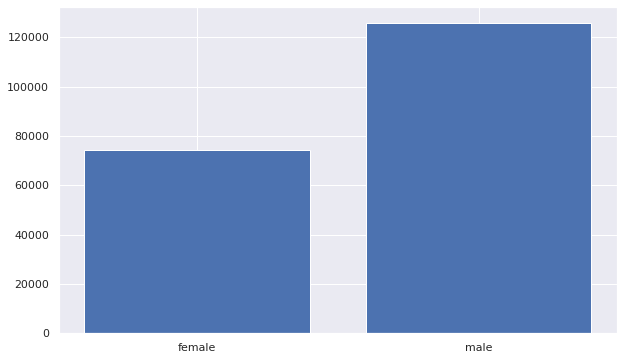

In [11]:
#グラフの大きさの設定
plt.figure(figsize=(10,6))

#性別の数を確認する
plt.bar(tmp.index, tmp.count_sex)
plt.show()

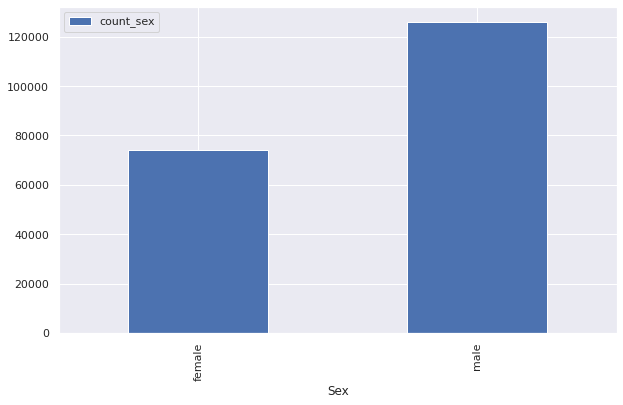

In [12]:
#pandasで棒グラフを作成
tmp.plot(kind='bar', figsize= (10,6))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


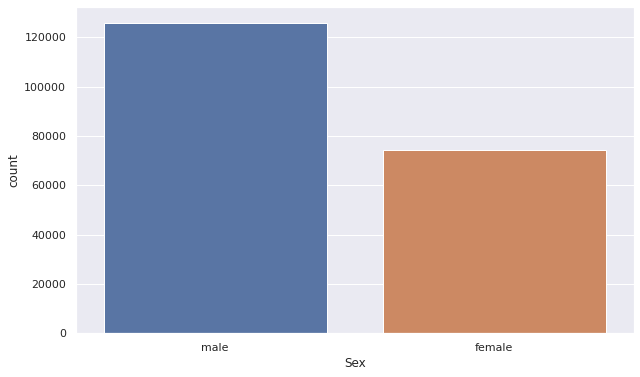

In [13]:
# グラフの大きさを設定
plt.figure(figsize=(10,6))


# 性別の数を確認してみる
sns.countplot('Sex', data = df)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


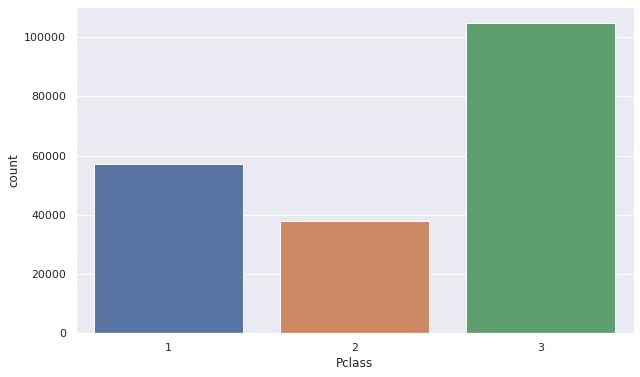

In [14]:
#チケットクラスの可視化
plt.figure(figsize=(10,6))

# seabornで棒グラフを作成する

sns.countplot('Pclass', data = df)

In [15]:
#データ内の欠損値を確認
df.isnull().sum()

PassengerId         0
Survived       100000
Pclass              0
Name                0
Sex                 0
Age              6779
SibSp               0
Parch               0
Ticket           9804
Fare              267
Cabin          138697
Embarked          527
dtype: int64

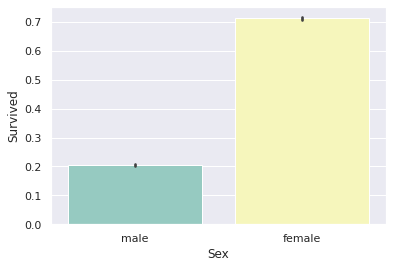

In [16]:
#Sexと生存率の関係
sns.barplot(x = 'Sex', y = 'Survived' , data =df , palette  ='Set3')
plt.show()  

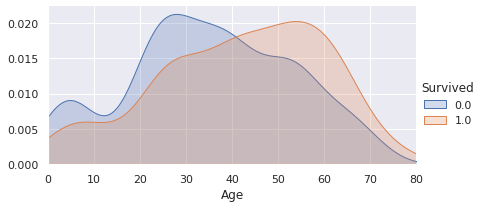

In [17]:
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
age_df = df[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df=pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

X = known_age[:, 1:]
y = known_age[:, 0]

#ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
df.loc[(df.Age.isnull()), 'Age'] = predictedAges 

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()


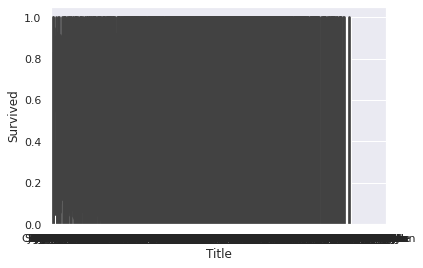

In [17]:
# ------------ Name --------------
# Nameから敬称(Title)を抽出し、グルーピング
df['Title'] = df['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
df['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df['Title'].replace(['Mlle'], 'Miss', inplace=True)
df['Title'].replace(['Jonkheer'], 'Master', inplace=True)
sns.barplot(x='Title', y='Survived', data=df, palette='Set3')

In [18]:
# NameからSurname(苗字)を抽出
df['Surname'] = df['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df['FamilyGroup'] = df['Surname'].map(df['Surname'].value_counts()) 

Female_Child_Group=df.loc[(df['FamilyGroup']>=2) & ((df['Age']<=16) | (df['Sex']=='female'))]
Female_Child_Group=Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

1.000000    6583
0.000000    2950
0.500000    1748
0.666667     697
0.750000     302
            ... 
0.651163       1
0.627451       1
0.709677       1
0.648352       1
0.672000       1
Name: Survived, Length: 219, dtype: int64


In [19]:
# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df.loc[(df['FamilyGroup']>=2) & (df['Age']>16) & (df['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())


0.000000    9098
1.000000    1596
0.500000    1236
0.333333     606
0.250000     345
            ... 
0.242105       1
0.555556       1
0.147368       1
0.193043       1
0.218487       1
Name: Survived, Length: 206, dtype: int64


In [20]:
# デッドリストとサバイブリストの作成
Dead_list=set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list=set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df.loc[(df['Survived'].isnull()) & (df['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

             

Dead_list =  {'Stobie', 'Minion', 'Orabuena', 'Upshur', 'Bazaldua', 'Bonnette', 'Springfield', 'Mclaurin', 'Ealand', 'Pellowski', 'Magnie', 'Hartrick', 'Runion', 'Wente', 'Bashore', 'Hedley', 'Kershaw', 'Arreaga', 'Blume', 'Terrano', 'Paulk', 'Bazile', 'Clack', 'Elderidge', 'Hutsell', 'Kosloski', 'Bowar', 'Saez', 'Peredo', 'Collingwood', 'Mudd', 'Gremo', 'Huls', 'Mcgarvey', 'Alberson', 'Cassidy', 'Bos', 'Kleiman', 'Sova', 'Purcell', 'Cordoua', 'Maier', 'Rainbolt', 'Carlone', 'Daigle', 'Martell', 'Ashford', 'Cyphers', 'Dibari', 'Seyler', 'Heagney', 'Ketcher', 'Dansereau', 'Livingstone', 'Enos', 'Fenwick', 'Nettles', 'Boulanger', 'Lacoy', 'Lautman', 'Newborn', 'Cable', 'Sphon', 'Betancourt', 'Campana', 'Gravina', 'Rochon', 'True', 'Basinski', 'Caulder', 'Bambenek', 'Varney', 'Abramson', 'Hillard', 'Olufson', 'Narain', 'Teel', 'Sturmer', 'Herkert', 'Santo', 'Deubler', 'Vissering', 'Schaus', 'Natcher', 'Kinyon', 'Sikora', 'Entrekin', 'Paugh', 'Philpott', 'Alsip', 'Balderas', 'Rothrock', 'F

In [21]:
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare=df.loc[(df['Embarked'] == 'S') & (df['Pclass'] == 3), 'Fare'].median()
df['Fare']=df['Fare'].fillna(fare)

In [22]:
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
df['Family']=df['SibSp']+df['Parch']+1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

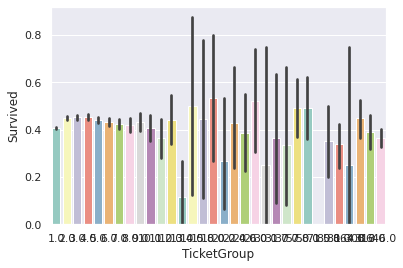

In [23]:
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())
df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()


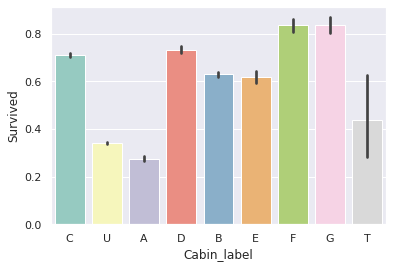

In [24]:
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

In [25]:
# 欠損値をSで補完
df['Embarked'] = df['Embarked'].fillna('S') 

In [30]:
# 推定に使用する項目を指定
df = df[['Survived','Pclass','Sex','Age','Fare','Embarked','Title','Family_label']]

# ラベル特徴量をワンホットエンコーディング
df = pd.get_dummies(df)

# データセットを trainとtestに分割
train = df[df['Survived'].notnull()]
test = df[df['Survived'].isnull()].drop('Survived',axis=1)

# データフレームをnumpyに変換
X = train.values[:,1:]  
y = train.values[:,0] 
test_x = test.values


KeyError: ignored

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate

# 採用する特徴量を25個から20個に絞り込む
select = SelectKBest(k = 20)

clf = RandomForestClassifier(random_state = 10, 
                             warm_start = True,  # 既にフィットしたモデルに学習を追加 
                             n_estimators = 26,
                             max_depth = 6, 
                             max_features = 'sqrt')
pipeline = make_pipeline(select, clf)
pipeline.fit(X, y)

# フィット結果の表示
cv_result = cross_validate(pipeline, X, y, cv= 10)
print('mean_score = ', np.mean(cv_result['test_score']))
print('mean_std = ', np.std(cv_result['test_score']))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 9 10] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 9 10] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 9 10] are constant.
  UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.7/dist-pack

mean_score =  0.7723399999999999
mean_std =  0.005648929102051106


In [32]:
# 採用の可否状況
mask= select.get_support()

# 項目のリスト
list_col = list(df.columns[1:])

# 項目別の採用可否の一覧表
for i, j in enumerate(list_col):
    print('No'+str(i+1), j,'=',  mask[i])

# シェイプの確認
X_selected = select.transform(X)
print('X.shape={}, X_selected.shape={}'.format(X.shape, X_selected.shape))

No1 Pclass = True
No2 Age = True
No3 Fare = True
No4 Family_label = True
No5 Sex_female = True
No6 Sex_male = True
No7 Embarked_C = True
No8 Embarked_Q = True
No9 Embarked_S = True
No10 Title_Mr = True
No11 Title_Mrs = True
No12 Cabin_label_A = True
No13 Cabin_label_B = True
No14 Cabin_label_C = True
No15 Cabin_label_D = True
No16 Cabin_label_E = True
No17 Cabin_label_F = True
No18 Cabin_label_G = True
No19 Cabin_label_T = True
No20 Cabin_label_U = True
X.shape=(100000, 20), X_selected.shape=(100000, 20)


In [35]:
# ----- Submit dataの作成　------- 
PassengerId=test_df['PassengerId']
predictions = pipeline.predict(test_x)
submission = pd.DataFrame({"PassengerId": PassengerId, "Survived": predictions.astype(np.int32)})
submission.to_csv("my_submission.csv", index=False)